In [ ]:
# install the required packages
!pip install bioread
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tk


In [16]:
# import the necessary libraries and create functions
try:
    import bioread
    import matplotlib.pyplot as plt
    import os
    import pandas as pd
    import numpy as np
    import tkinter as tk
    from tkinter import*
    from tkinter import filedialog
    import scipy.signal as sig
    import math

    current_path = os.getcwd()
    print("All necessary libraries are installed successfully")
    print("Current working directory is: ", current_path)
except ImportError:
    print("Please install the necessary libraries using 'pip install -r requirements.txt' before running the script")
    exit(1)

def select_file():
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    file_path = filedialog.askopenfilename()
    return file_path

def load_acq(file_path = None, channel_number = 0):

    if file_path is None:
      file_path = select_file()

    if not os.path.exists(file_path):
        print('File not found')
        exit(1)

    data = bioread.read_file(file_path)
    emg_data = data.channels[channel_number].data
    fs = data.samples_per_second

    emg_data_detrended = detrend_emg_signal(emg_data, data.samples_per_second)

    print('file path: ', file_path)
    print('EMG data:', emg_data)
    print('EMG data type:', type(emg_data))
    print('sampling rate:', fs)


    return file_path, emg_data_detrended, fs

def print_loading_bar(completion_ratio):
    # Define bar length and characters
    bar_length = 20  # Adjust for desired visual length
    completed_char = '='
    remaining_char = ' '

    # Calculate completed and remaining sections
    completed_sections = int(math.floor(completion_ratio * bar_length))
    remaining_sections = bar_length - completed_sections

    # Build the progress bar string
    progress_bar = completed_char * completed_sections + remaining_char * remaining_sections

    # Print the progress bar and optional percentage
    print(f"\rProgress: [{progress_bar}] {completion_ratio:.2%}", end="")

def plot_segment_h_m (segment_emg,sample_rate,savedir, m_latency = 0.02, h_latency_begin = 0.03, h_latency_end = 0.045):
    # M-wave calculate peak to peak amplitude after 12 miliseconds
    try:
      m_time_frame = int(m_latency*sample_rate)
      peak_to_peak_m = np.max(segment_emg[5:m_time_frame]) - np.min(segment_emg[3:m_time_frame])
    except:
      peak_to_peak_m = np.nan

    # H-reflex calculate peak to peak amplitude after between 15 and 35 miliseconds
    try:
      h_time_frame = int(h_latency_begin*sample_rate)
      h_time_frame_end = int(h_latency_end *sample_rate)
      peak_to_peak_h = np.max(segment_emg[h_time_frame:h_time_frame_end]) - np.min(segment_emg[h_time_frame:h_time_frame_end])
    except:
      peak_to_peak_h = np.nan

    plt.plot(segment_emg)
    plt.axvline(x=5, linestyle = 'dashed', label = 'start M-wave')
    plt.axvline(x=m_time_frame, linestyle = 'dashed', label = 'end M-wave')
    plt.axvline(x=h_time_frame, linestyle = 'dashed', label = 'start H-reflex')
    plt.axvline(x=h_time_frame_end, linestyle = 'dashed', label = 'end H-reflex')

    plt.savefig(savedir)
    plt.close()

    return peak_to_peak_m, peak_to_peak_h

def find_last_non_nan(arr):
            for i in range(len(arr)-1, -1, -1):
              if not np.isnan(arr[i]):
                return arr[i], i
            return -1   

def split_and_save_to_csv(data, sample_rate, filename_base, threshold = 0.25):
  """
  Splits a NumPy ndarray (data) into sections of specified size (chunk_size_seconds)
  based on the sample rate and saves them as separate CSV files with an incremental base filename.
  For each chunk, it finds the first peak above a threshold and all peak frames, storing them in a list.

  Args:
      data: The NumPy ndarray to be split.
      sample_rate: The sampling rate of the data in Hz.
      filename_base: The base filename for the output CSV files (e.g., "my_data_").
      chunk_size_seconds: The size of each chunk in seconds (default: 10).

  Returns:
      A list of lists, where each inner list contains peak frames for a corresponding chunk.
  """
  # Create save folder
  if not os.path.exists(os.path.dirname(filename_base)):
    os.makedirs(os.path.dirname(filename_base))

  cont = 1
  data_to_cut = data
  peak_frames_list = []
  count = 0
  while cont == 1:
    count += 1
    # Check next spike above threshold and cut the data
    for i in range(len(data_to_cut)): 
      if data_to_cut[i] > threshold:                                # Find the first peak above a threshold (e.g., 0.5)
        data_section = data_to_cut[i-2:i-2+int(sample_rate*0.06)]   # Cut the data from the peak to 60 ms after the peak
        data_to_cut = data_to_cut[i-2+int(sample_rate*0.06):]                             # Cut the data from the peak to the end 
        break
      elif len(data_to_cut) == i+1:  # if gets to the end of the data without finding a peak above the threshold
        cont = 0
        break

    # Check if the data section is too short
    if len(data_to_cut) < sample_rate*0.06:
      print("data process completed")
      break
    else:
      completion_ratio = 1 - (len(data_to_cut) / len(data))
      print_loading_bar(completion_ratio)
    
    # calculate the peak to peak amplitude of the M-wave and H-reflex
    filename = f"{filename_base}{count}.csv"
    csv_file_to_save = filename.replace('.csv','.png')
    peak_to_peak_m, peak_to_peak_h = plot_segment_h_m (data_section,sample_rate,csv_file_to_save)

    # Save the cropped chunk to a CSV file and store peak frames
    np.savetxt(filename, data_section, delimiter=",")  
    peak_frames_list.append({"filename": os.path.basename(filename), "threshold": threshold,
                              "peak_to_peak_m": peak_to_peak_m, "peak_to_peak_h": peak_to_peak_h})

    peak_frames_df = pd.DataFrame(peak_frames_list)

  return peak_frames_df

def detrend_emg_signal(emg_signal, sample_rate, cutoff_freq=10):
  """
  Detrends an EMG signal using a high-pass Butterworth filter.
  """
  # Calculate Nyquist frequency
  nyquist_freq = 0.5 * sample_rate

  # Normalize cutoff frequency
  cutoff_freq_normalized = cutoff_freq / nyquist_freq

  # Apply high-pass Butterworth filter
  b, a = sig.butter(4, cutoff_freq_normalized, btype="high", analog=False)
  emg_signal_detrended = sig.filtfilt(b, a, emg_signal)

  return emg_signal_detrended

def save_acq_as_csv():
    file_path, emg_data, fs = load_acq()
    emg_data_detrended = detrend_emg_signal(emg_data, fs)
    np.savetxt(file_path.replace('.acq','.csv'), emg_data_detrended, delimiter=",")

def plot_first_20_sec(channel_number = 0):

    file_path = select_file()
    data = bioread.read_file(file_path)
    column = data.channels[channel_number].data
    detrend_column = detrend_emg_signal(column, data.samples_per_second)


    # Create a figure with one subplot
    fig, ax = plt.subplots()
    ax.plot(column[:20000], label='Original Data')  # Add label for clarity
    ax.plot(detrend_column[:20000], label='Detrended Data', color='red')  # Add label and color

    # Add labels and title
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('EMG Signal (mV)')
    ax.set_title('Original vs. Detrended EMG Signal')

    plt.legend('raw', 'detrended')
    plt.show()

    print('mean data:', np.mean(detrend_column[:20000]))



All necessary libraries are installed successfully
Current working directory is:  c:\Git\msk_modelling_python\src\neuro


In [ ]:
plot_first_20_sec()

In [17]:
# Load data and print some information
import sys
file_path, emg_data, fs = load_acq()

if emg_data is None or fs is None:
    print('Error loading data')
    sys.exit(1) 

file_name_no_ext = os.path.splitext(os.path.basename(file_path))[0]
save_path = os.path.join(os.path.dirname(file_path), file_name_no_ext + '_splits',"data_segments_")

peak_frames_per_chunk = split_and_save_to_csv(emg_data, fs, save_path,threshold = 0.5)

# save the peak frames per chunk to a csv file
peak_frames_per_chunk.to_csv(os.path.join(os.path.dirname(save_path),"peak_frames_per_chunk.csv"), index=False)
print('save data in:' , os.path.dirname(file_path))
print('N of peaks found:' , len(peak_frames_per_chunk))

file path:  C:/Users/Bas/ucloud/BSc_thesis_S2024/Lukas_Weilharter/data/session7/rc_good_lateral_part_LG.acq
EMG data: [-6.16455078 -6.16455078 -6.16455078 ... -0.06103516 -0.06103516
 -0.09155273]
EMG data type: <class 'numpy.ndarray'>
sampling rate: 1000.0
Progress: [=================== ] 99.14%save data in: C:/Users/Bas/ucloud/BSc_thesis_S2024/Lukas_Weilharter/data/session7
N of peaks found: 91


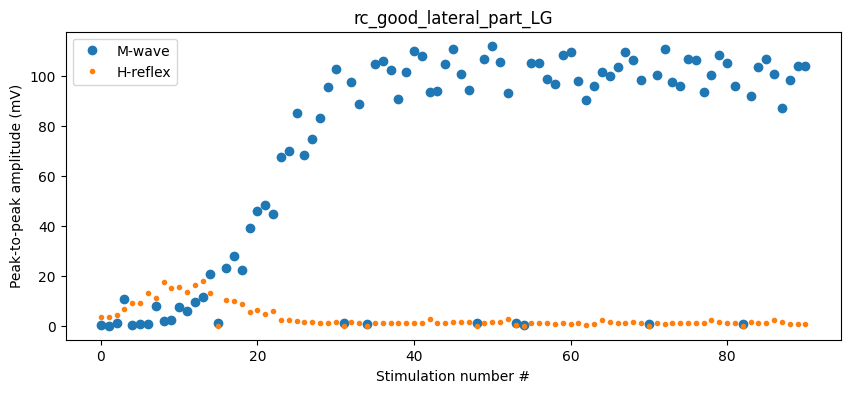

In [6]:
# Plot average every X frames
m = peak_frames_per_chunk["peak_to_peak_m"].rolling(1).mean()
h = peak_frames_per_chunk["peak_to_peak_h"].rolling(1).mean()
x = np.arange(len(m))

# plotting peak frames
plt.figure(figsize=(10, 4))
plt.plot(x,m,marker='o', linestyle='None')
plt.plot(x,h,marker='.', linestyle='None')
plt.legend(["M-wave", "H-reflex"])
plt.xlabel("Stimulation number #")
plt.ylabel("Peak-to-peak amplitude (mV)")
plt.title(file_name_no_ext)
plt.savefig(file_path.replace('.acq','_RC.png'))